In [131]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import choice
from random import sample
from random import random

import torch
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
from torch import optim


%config Completer.use_jedi = False
%matplotlib inline

## Using XOR as a simple example of a non-linearly separable dataset.

In [132]:
def generate_xor_data(n):
    x_vals = []
    y_vals = []
    for _ in range(n):
        x = [(random()-.5)*50 for x in range(2)]
        y = 0
        if (x[0] > 0 and x[1] < 0) or (x[0] < 0 and x[1] > 0):
            y = 1
        y_vals.append(y)
        x_vals.append(x)
    return torch.tensor(x_vals), torch.tensor(y_vals)

## Simple ANN with 2 hidden layers

In [133]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 4)
        self.layer2 = nn.Linear(4, 8)
        self.layer3 = nn.Linear(8, 4)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = self.log_softmax(x)
        return x

## Example of inspecting activations after passing toy data thru model

In [134]:
# Create an instance of your network
model = MyNetwork()

# Define a dictionary to store the layer activations
layer_activations = {}

# Define a hook function to store the activations
def get_activations(name):
    def hook(model, input, output):
        layer_activations[name] = output.detach()
    return hook

# Register hooks for each layer
model.layer1.register_forward_hook(get_activations('layer1'))
model.layer2.register_forward_hook(get_activations('layer2'))
model.layer2.register_forward_hook(get_activations('layer3'))


# Perform inference on a sample input
input_data = torch.randn(1, 2)
output = model(input_data)

# Access the layer activations
print(layer_activations['layer1'])
print(layer_activations['layer2'])
print(layer_activations['layer3'])
print("output: ", output)

tensor([[-0.5091, -0.3425,  1.6089, -0.8881]])
tensor([[ 0.3903,  0.2890, -0.5661, -0.2100, -1.1111, -0.2313,  0.3143,  0.0567]])
tensor([[ 0.3903,  0.2890, -0.5661, -0.2100, -1.1111, -0.2313,  0.3143,  0.0567]])
output:  tensor([[-1.4303, -1.5381, -1.4495, -1.1671]], grad_fn=<LogSoftmaxBackward0>)


## Training the model on XOR data.

In [135]:
# Create an instance of the network
model = MyNetwork()

# Define a dictionary to store the layer activations
layer_activations = {}

# Define a hook function to store the activations
def get_activations(name):
    def hook(model, input, output):
        layer_activations[name] = output.detach()
    return hook

# Register hooks for each layer
model.layer1.register_forward_hook(get_activations('layer1'))
model.layer2.register_forward_hook(get_activations('layer2'))
model.layer2.register_forward_hook(get_activations('layer3'))

# Hyperparameters
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

data, labels = generate_xor_data(1000)

# Train the network
epochs = 500
for e in range(epochs):
    optimizer.zero_grad()
    logps = model(data)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    if e % 100 == 0:
        print(f"Training loss: {loss.item()}")
print(f"Final training loss: {loss.item()}")

Training loss: 1.510488748550415
Training loss: 0.4562153220176697
Training loss: 0.38712945580482483
Training loss: 0.3452731966972351
Training loss: 0.312555730342865
Final training loss: 0.28564727306365967


## Perform inference and confirm the model has learned XOR

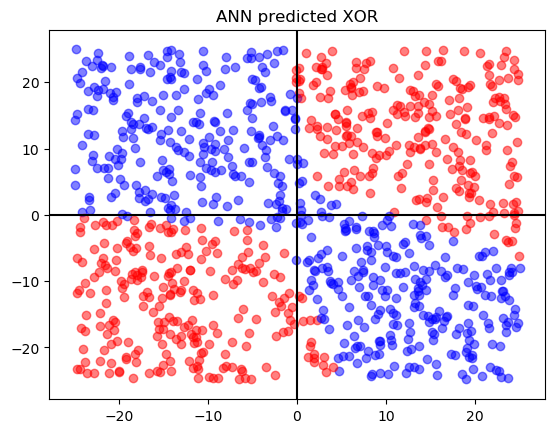

In [136]:
size = len(data)
d, l = generate_xor_data(size)
pred = model(d)
d = d.permute(1, 0)

labels = torch.argmax(pred, 1)
c = ["red", "blue"]

fig, ax = plt.subplots()
for i in range(size):
    ax.scatter(d[0][i], d[1][i], c=c[labels[i]], alpha=0.5)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_title("ANN predicted XOR")
plt.show()


## Linear Probes using sklearn logistic regression

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [138]:
# Get the activations: These serve as the features for their respective regression model.
raw_input = d.T
layer1 = layer_activations['layer1']
layer2 = layer_activations['layer2']
layer3 = layer_activations['layer3']
features = [raw_input, layer1, layer2, layer3]

# 'Concepts': These serve as labels for the regression models.
up_down_target = [0 if i[1]>0 else 1 for i in raw_input] # Top half vs bottom half.
left_right_target = [0 if i[0]>0 else 1 for i in raw_input] # Left side vs. right side.
x_or_target = l                                             # x_or value, identical to training label.
targets = [up_down_target, left_right_target, x_or_target]

# Create a model for each (features, target) pair. 
models = [[LogisticRegression() for i in range(4)] for y in targets]

# Train all of the models.
for i, target in enumerate(targets):
    for j, model in enumerate(models[i]):
        model.fit(features[j], target)

# Print the loss for each model against the XOR target.
for i, model in enumerate(models[2]):
    y_pred_probabilities = model.predict_proba(features[i])
    print(log_loss(target, y_pred_probabilities))

0.6916212630734553
0.6916212631768901
0.13207605016603133
0.13207605016603133


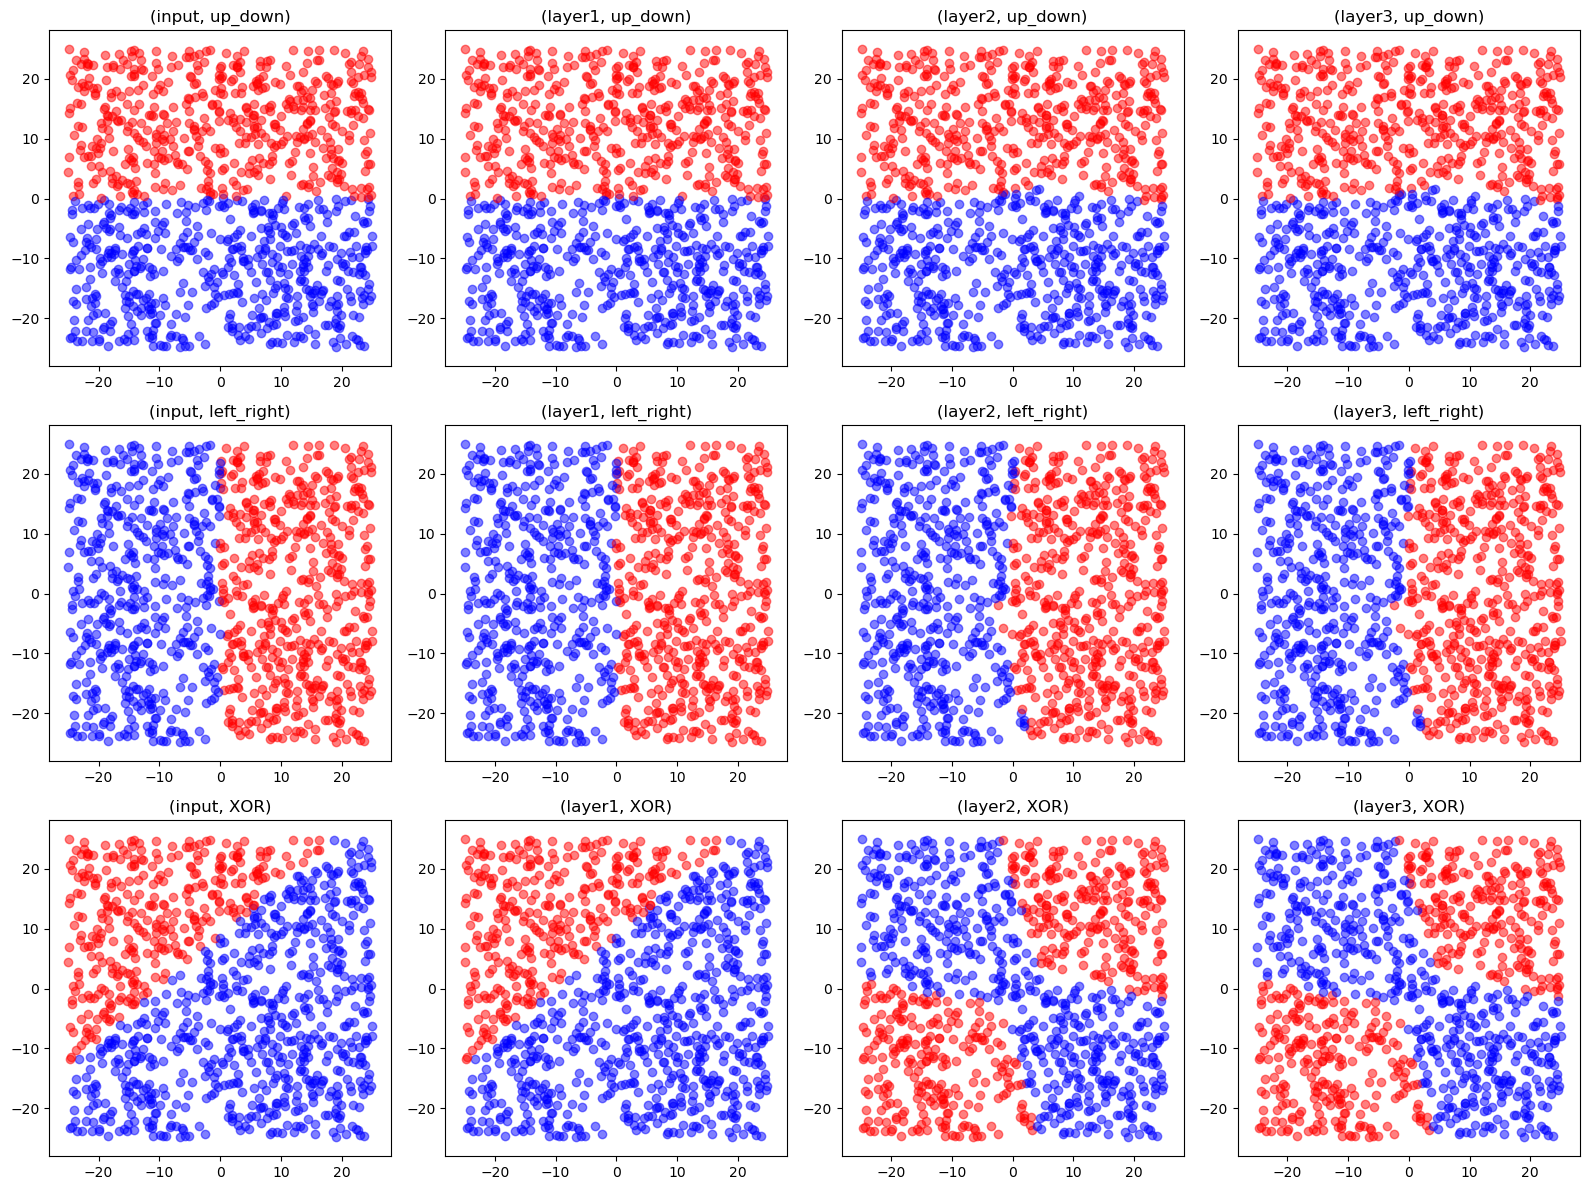

In [139]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
c = ["red", "blue", "green", "purple"]

feature_title = ["input", "layer1", "layer2", "layer3"]
concept_title = ["up_down", "left_right", "XOR"]

# Plot the data on each subplot
for i in range(3):
    for j in range(4):
        pred = models[i][j].predict(features[j])
        ax = axes[i][j]
        ax.set_title(f'({feature_title[j]}, {concept_title[i]})')
        for k in range(size):
            ax.scatter(raw_input[k][0], raw_input[k][1], c=c[pred[k]], alpha=0.5)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Conclusions
This shows that for linearly separable data, the logistic models are able to learn the labels (even from the raw input itself). However for XOR, a logistic regression model is only able to effectively learn the labels using the activations of the second hidden layer, and further hidden layers are redundant and add no further information.